<a href="https://colab.research.google.com/github/sinhajiya/Projects-Python/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALLING PACKAGES

In [1]:
import tensorflow as tf

In [2]:
import os

In [38]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [18]:
import cv2
import imghdr

#LOADING DATA

In [25]:
data_dir = '/content/img_classification/data'

In [27]:
img_ext = ['jpeg', 'jpg', 'png','bmp']

In [32]:
os.listdir(data_dir)

['happy', '.ipynb_checkpoints', 'sad']

In [ ]:
os.listdir(os.path.join(data_dir,'sad'))

In [35]:
for image_class in os.listdir(data_dir):
    print(image_class)

happy
.ipynb_checkpoints
sad


In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
          img=cv2.imread(image_path)
          tip = imghdr.what(image_path)
          if tip not in img_ext:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}")



* Creating data pipeline

In [65]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 412 files belonging to 2 classes.


In [40]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

* To access data pipeline

In [41]:
data_iterator = data.as_numpy_iterator()

* Accessing data pipeline

In [48]:
batch = data_iterator.next()

In [43]:
len(batch)

2

* 2 means there are 2 parts of the data: images and labels.

In [44]:
batch[0].shape

(32, 256, 256, 3)

* *Images represented as numpy array*

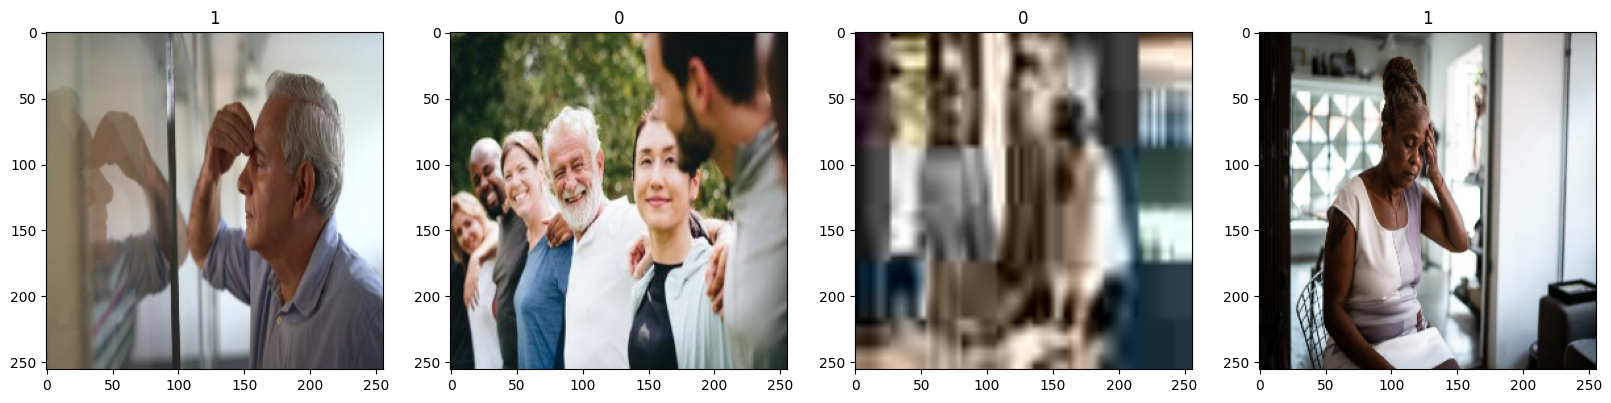

In [49]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

* *0 is happy*
* *1 is sad*

# **PREPROCESS DATA**




* scale image value between 0 to 1 (instead of 0 to 255)
* split to train,test and validation data

***SCALING DATA***

* x is images
* y is target variable

In [66]:
data = data.map(lambda x,y: (x/255.0,y))

In [67]:
scaled_iterator = data.as_numpy_iterator()

In [68]:
batch = scaled_iterator.next()

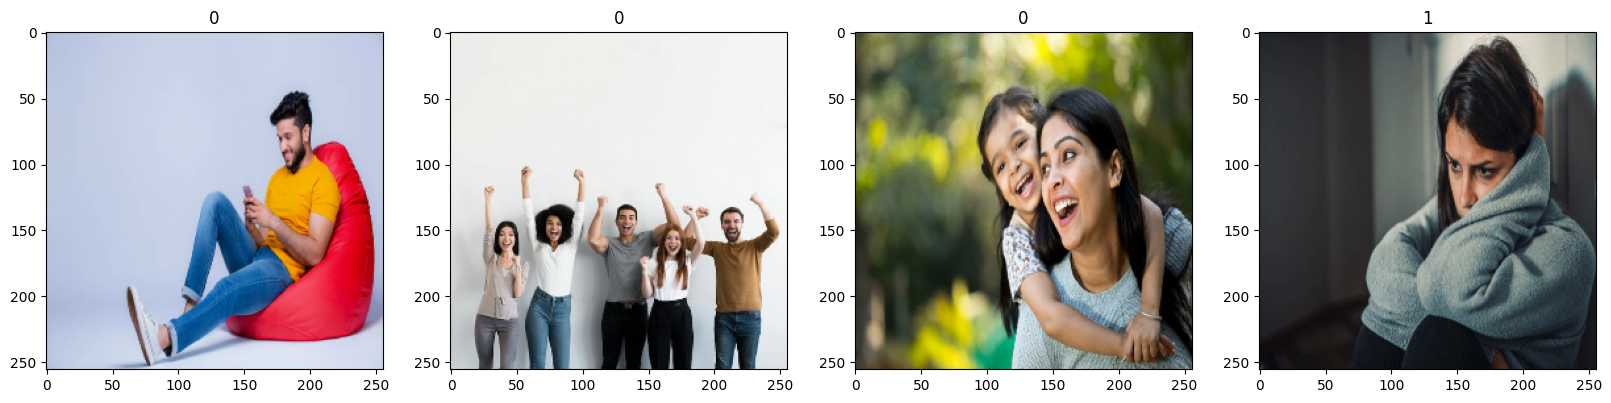

In [69]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

* ***Split Data***

In [71]:
len(data)

13

In [77]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [81]:
test_size+train_size+val_size

13

In [82]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [84]:
len(test)

1

#**DEEP LEARNING MODEL**

* Importing Libraries

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential([
    #16 filter of size (3,3) and stride = 1
    Conv2D(16,(3,3),1,activation='relu', input_shape = (256,256,3)),
    MaxPooling2D(),  #gives max of the 2x2 region (default)

    Conv2D(32,(3,3),1,activation='relu'),
    MaxPooling2D(),

    Conv2D(16,(3,3),1,activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(256,activation='relu'),
    Dense(1,activation='sigmoid')

])

model.compile(
    optimizer="adam",
    loss = tf.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)


In [ ]:
model.summary()

* ***Training data***

In [110]:
logdir = '/content/img_classification/logs'

In [111]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20,validation_data = val, callbacks=[tensorboard_callback])

* Plotting

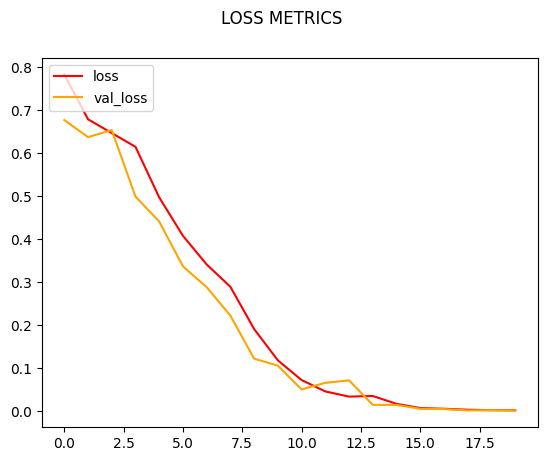

In [116]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label= 'loss')
plt.plot(hist.history['val_loss'],color = 'orange',label='val_loss')
fig.suptitle("LOSS METRICS")
plt.legend(loc="upper left")
plt.show()

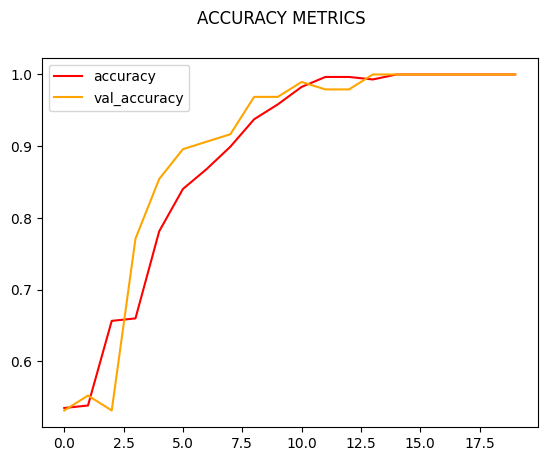

In [117]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'red', label= 'accuracy')
plt.plot(hist.history['val_accuracy'],color = 'orange',label='val_accuracy')
fig.suptitle("ACCURACY METRICS")
plt.legend(loc="upper left")
plt.show()

# **EVALUATING DATA**

In [118]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [119]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [121]:
for batch in test.as_numpy_iterator():
  X,y=batch
  yhat = model.predict(X)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)


1/1 [==============================] - 0s 36ms/step
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [123]:
print (pre.result().numpy(),re.result().numpy(), acc.result().numpy())

1.0 1.0 1.0


* Testing data

In [127]:
%ls

data/  happy.jpg  logs/  models/  sad.jpg  untitled


In [129]:
test_happy_path = "/content/img_classification/happy.jpg"
test_sad_path = "/content/img_classification/sad.jpg"

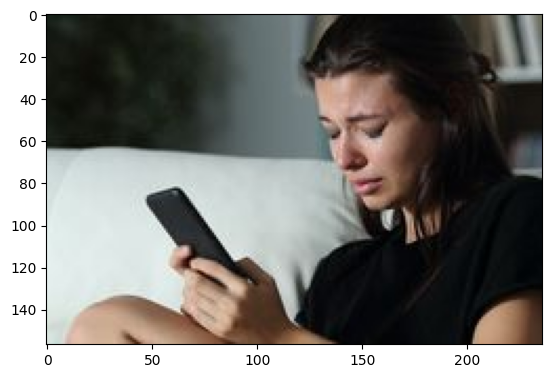

In [133]:
img = cv2.imread(test_sad_path)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

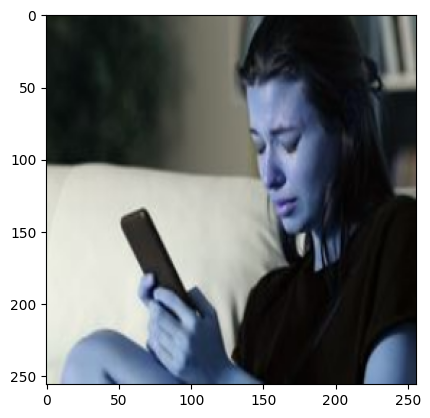

In [134]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [135]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 396ms/step


In [136]:
yhat

array([[0.9960821]], dtype=float32)

* close to 1.
* 1 denotes SAD.
* CORRECT PREDICTION!

In [137]:
if yhat > 0.5:
  print("SAD")
else:
  print("HAPPY")

SAD


# **SAVING**

In [138]:
from tensorflow.keras.models import load_model

In [141]:
model.save(os.path.join('models',"imageclassifier_happy-sad.h5"))

In [142]:
new_model = load_model("/content/img_classification/models/imageclassifier_happy-sad.h5")